# Team mates:


### Hari Krishna, Likith Kumar, Sai Kiran

In [1]:
# Importing the required libraries. 

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pymysql.cursors
import pandas as pd
%matplotlib inline

In [2]:
#Making a connection to the database and fetching all the data. 

connection = pymysql.connect(host='localhost',
                             user='root',
                             password='root',
                             db='projectdb',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
try:
    with connection.cursor() as cursor:
        sql = "SELECT * FROM newyork_taxi_data"
        cursor.execute(sql)
        all_data = cursor.fetchall()    
finally:
    connection.close()
    
df_all_data = pd.DataFrame(all_data)

## Question - 1

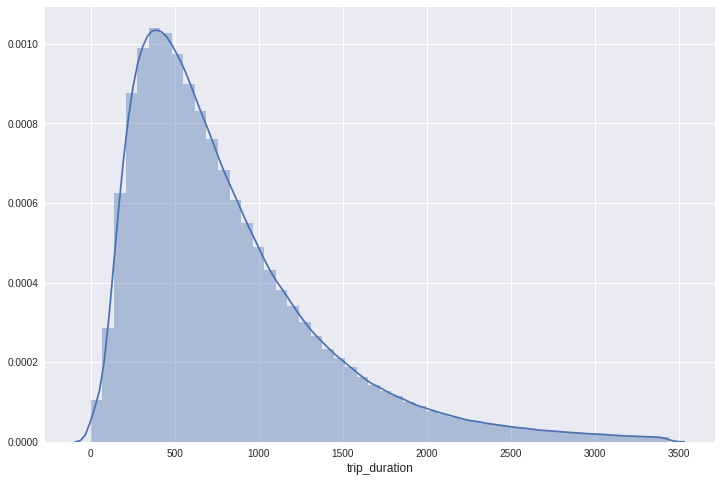

In [3]:
import seaborn as sns

#Original data has lots of outliers. In the range of 2000000 as the time duration. Hence removing those by 
#considering only top 99 percentile of the data. 
q = df_all_data.trip_duration.quantile(0.99)
df_all_data = df_all_data[df_all_data.trip_duration < q]
plt.figure(figsize=(12,8))
sns.distplot(df_all_data.trip_duration.values, bins=50, kde=True)
plt.xlabel('trip_duration', fontsize=12)
plt.show()

In [4]:
print("Mean of trip_duration: %.2f"%np.mean(df_all_data['trip_duration']))
print("Standard Deviation of trip_duration: %.2f"%np.std(df_all_data['trip_duration']))

Mean of trip_duration: 807.46
Standard Deviation of trip_duration: 575.42


## Question - 2

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

import random
random.seed(123)
df_all_data = df_all_data.sample(7000)

X_train, X_test, Y_train, Y_test = train_test_split(df_all_data,df_all_data['trip_duration'],
                                                    test_size=0.3, random_state=123)

#The features are categorical. Hence removing them. 
X_train = X_train.drop(['id','store_and_fwd_flag','pickup_datetime','dropoff_datetime','trip_duration'], axis=1)
X_test = X_test.drop(['id','store_and_fwd_flag','pickup_datetime','dropoff_datetime','trip_duration'], axis=1)



#Intializing the Gaussian Process Regressor
gp = GaussianProcessRegressor()

#Fitting the model 
gp.fit(X_train, Y_train)

#Predictions
train_pred = gp.predict(X_train)
test_pred= gp.predict(X_test)


# The root mean squared error calculation
print("Root Mean Square for train %.3f"
      % np.sqrt(mean_squared_error(Y_train, train_pred)))

print("Root Mean Square for test %.3f"
      % np.sqrt(mean_squared_error(Y_test, test_pred)))

Root Mean Square for train 333.008
Root Mean Square for test 21337.652


## Question - 3

In [8]:
#WE DO NOT HAVE AREA CODES IN OUR DATASET. HENCE CREATING THE AREA CODES BY CLUSTERING THE DATA BY 
#LATITUDES AND LONGITUDES.

#Pre-req code for betterment of solution of Question-3's accuracy. 

# The idea is to report the time taken from one cluster to another cluster so that, we can get a better estimate
# of the starting time to reach a certain location.
from dateutil import parser
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

longitude = list(df_all_data.pickup_longitude) + list(df_all_data.dropoff_longitude)
latitude = list(df_all_data.pickup_latitude) + list(df_all_data.dropoff_latitude)

df_location = pd.DataFrame()
df_location['longitude'] = longitude
df_location['latitude'] = latitude

kmeans = KMeans(n_clusters=15, random_state = 123, n_init = 25).fit(df_location)
df_location['label'] = kmeans.labels_



df_all_data['pickup_cluster'] = kmeans.predict(df_all_data[['pickup_longitude','pickup_latitude']])
df_all_data['dropoff_cluster'] = kmeans.predict(df_all_data[['dropoff_longitude','dropoff_latitude']])


# Calculating the median time taken from one cluster to cluster-3 (chosen cluster).
cluster_to_cluster = pd.DataFrame(df_all_data.groupby(['pickup_cluster', 'dropoff_cluster'])['trip_duration'].median()).reset_index()
inter_cluster_distance=cluster_to_cluster.loc[cluster_to_cluster['dropoff_cluster'] == 3]
inter_cluster_distance=inter_cluster_distance[inter_cluster_distance.pickup_cluster!=3]

inter_cluster_distance.head()

#Since we now have the median trip duration values now, we can make better estimates of when to start!

,pickup_cluster,dropoff_cluster,trip_duration
3,0,3,659.5
18,1,3,2493.0
32,2,3,1069.0
62,4,3,1894.5
76,5,3,1004.0


In [9]:
# ACTUAL QUESTION
# Alternatively if we just want to report the overall median time

cluster_to_cluster.loc[cluster_to_cluster['dropoff_cluster'] == 3]['trip_duration'].median()

1004.0